In [207]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from matplotlib import cm
import pandas as pd
from scipy import constants as const

### Спектры различных типов лазров

Text(0.5, 1.0, 'Диапазоны генерации лазеров различных типов')

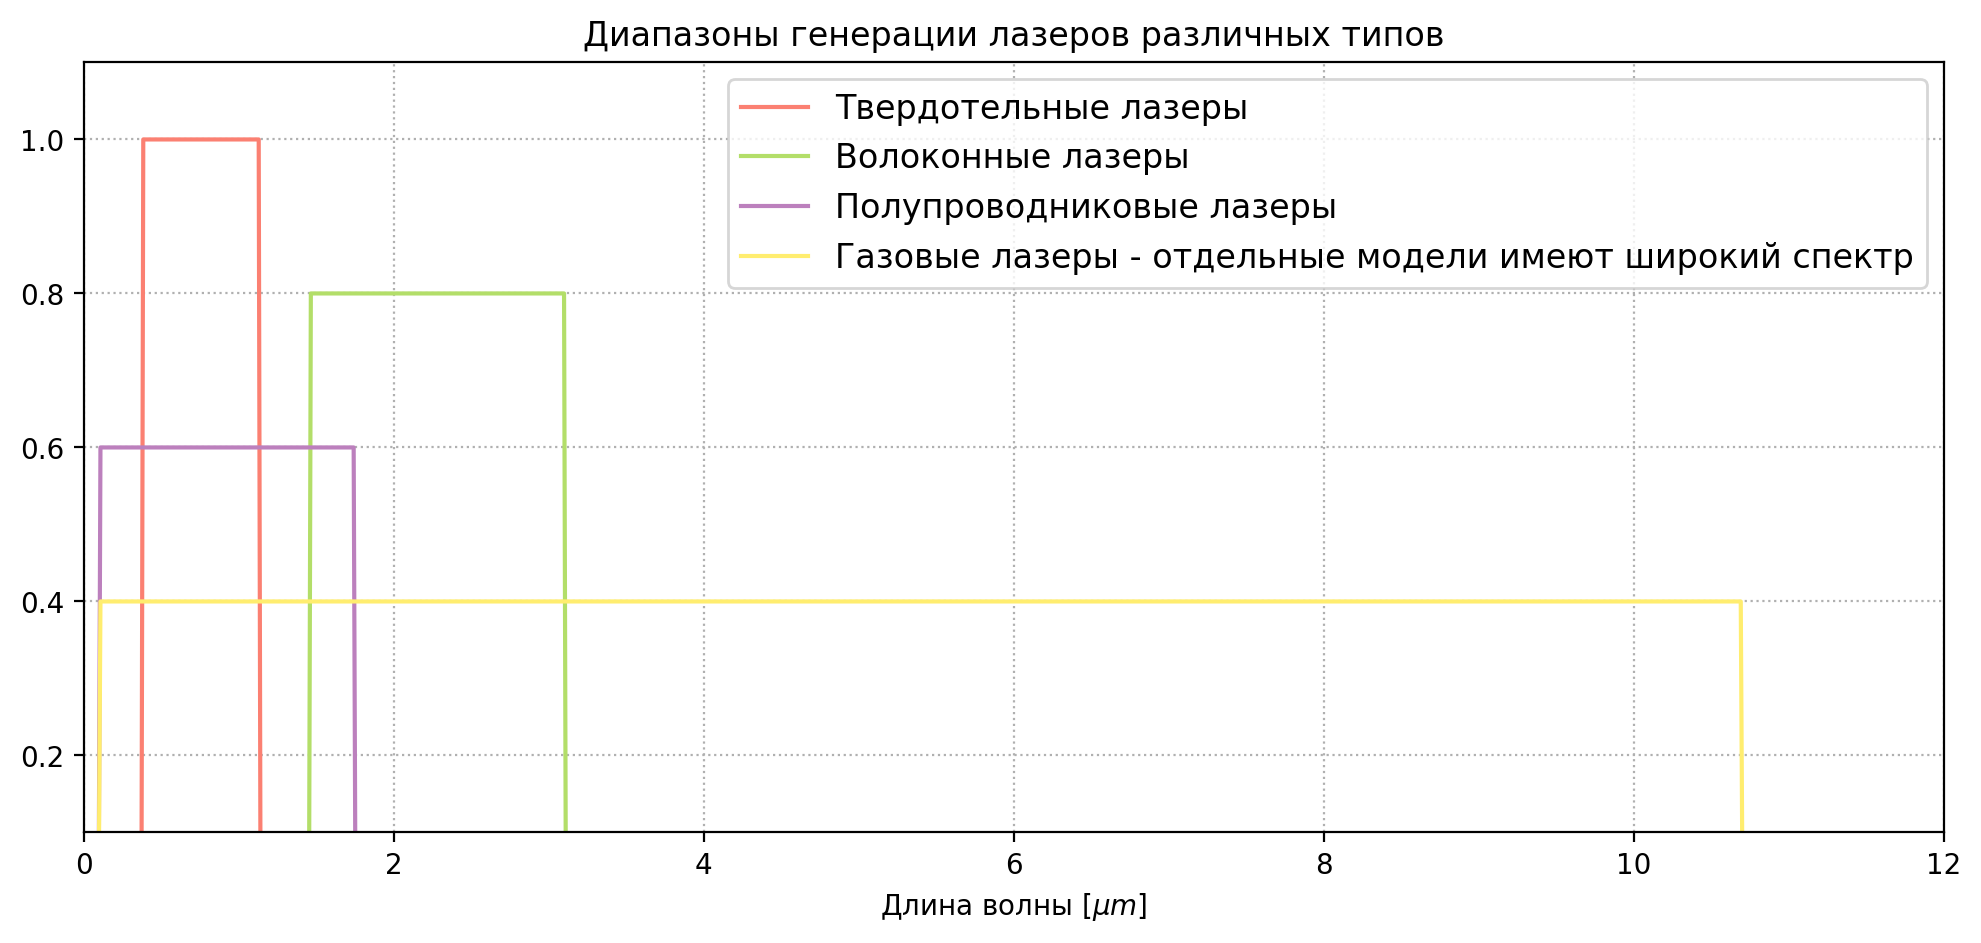

In [208]:
x = np.linspace(0, 12, 1000)

tverd = sts.uniform(380 / 1e3, 750 / 1e3)
volok = sts.uniform(1.46, 1.65)
poluprovod = sts.uniform(100 / 1e3, 1.65)
gas = sts.uniform(0.1, 10.6)

plt.figure(figsize = (12, 5), dpi = 200)
plt.xlabel("Длина волны [$\mu m$]")
plt.plot(x, tverd.pdf(x) / np.max(tverd.pdf(x) + 1e-6), label = 'Твердотельные лазеры', color = cm.Set3(1 / 4))
plt.plot(x, 0.8 * volok.pdf(x) / (np.max(volok.pdf(x)) + 1e-6), label = 'Волоконные лазеры', color = cm.Set3(2 / 4))
plt.plot(x, 0.6 * poluprovod.pdf(x) / (np.max(poluprovod.pdf(x)) + 1e-6), label = 'Полупроводниковые лазеры', color = cm.Set3(3 / 4))
plt.plot(x, 0.4 * gas.pdf(x) / (np.max(gas.pdf(x)) + 1e-6), label = 'Газовые лазеры - отдельные модели имеют широкий спектр', color = cm.Set3(4 / 4))
plt.legend(fontsize = 12)
plt.grid(ls = ':')
plt.ylim(0.1, 1.1)
plt.xlim(0, 12)
plt.title("Диапазоны генерации лазеров различных типов")

In [209]:
char = pd.read_csv('char.csv', dtype = np.float128)
print(np.log(np.abs(1 - char['T'])))
char['t0'] = (- 2 * char['L']) / (const.c * np.log(np.abs(1 - char['T'])))
char['w0'] = np.sqrt((char['x'] - 1) / (char['t0'] * char['tau'] * np.power(0.1, 6)))
char['type'] = ['HeNe', 'полупр', 'YAgNd3+', 'наш']

0   -0.223144
1   -0.430783
2   -0.105361
3   -0.223144
Name: T, dtype: float128


In [210]:
char['w0'] *= 1e-3 / (2 * np.pi) #килогерц
char['t0'] *= 1e6 #мкс
char['NuZhisni'] = 1e-3 / (char['tau'] * np.power(0.1, 6))
char.head()

,type,L,x,T,tau,t0,w0,NuZhisni
0,HeNe,0.20,1.5,0.20,1400.0,0.005979,38.896779,0.714286
1,полупр,0.01,1.5,0.35,7700.0,0.000155,103.058629,0.129870
2,YAgNd3+,1.00,1.5,0.10,230.0,0.063319,29.490050,4.347826
3,наш,1.00,1.5,0.20,1200.0,0.029897,18.788929,0.833333


In [211]:
T, B = 300, 0.5
N = 5000
N0 = 200
q = 10
t = np.linspace(1, 10, 10000)

n1 = np.exp(-B * q * t) * t * N0 / (np.exp(55) - 1)

plt.figure(figsize = (5, 5), dpi = 200)
plt.plot(t, n1 / np.max(n1))
plt.xlabel('t')
plt.ylabel('n1')

In [ ]:
np.exp(1.5 / (9 * 300 * 1e-5))

1.3411310481168085e+24

In [ ]:
tau = 2 * np.pi / 1e-7
l = 100
nu = 1 / (100 * 1e-9)
print(nu * 1e-6)
nu = 1 / tau
print(f"{nu:.2g}")

10.0
1.6e-08
